## Использование эмбеддингов пены с помощью encodera от VAE. Проверка гипотез

эмбеддинги пены нужны для их дальшейшей кластеризации

In [1]:
import os
import sys
sys.stdout.flush()
import time
import pandas as pd
import numpy as np
from tqdm import tqdm
from skimage import io
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split 
import cv2
import random

os.environ['CUDA_LAUNCH_BLOCKING'] = '0'

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms
from torchvision.utils import save_image
import albumentations as A
from torchsummary import summary

def see_plot(pict, color='gray', size=(4,4)):
    plt.figure(figsize=size)
    plt.imshow(pict, cmap=color)
    #plt.grid()
    plt.show()
    

#print(cv2.__version__) #4.5.1

path_to_video1 = '/media/laggg/flotation_nornik/dataset1-1/'
path_to_video2 = '/media/laggg/flotation_nornik/dataset1-2/'
all_frames_dir = '/media/laggg/flotation_nornik/all_frames/'
print(len(os.listdir(all_frames_dir)))

91919


(18384, 5) (20975, 4) (2006, 4)
<class 'numpy.ndarray'> (224, 224)


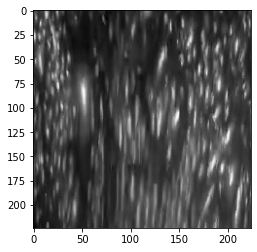

,index,img_path,video,frame,train
0,0,F7_1_1_1.ts_f_703.jpg,F7_1_1_1,f_703.jpg,1
1,5,F1_1_4_1.ts_f_1753.jpg,F1_1_4_1,f_1753.jpg,1
2,10,F1_1_2_2.ts_f_564.jpg,F1_1_2_2,f_564.jpg,1
3,15,F1_2_3_2.ts_f_340.jpg,F1_2_3_2,f_340.jpg,1
4,20,F4_1_1_2.ts_f_1352.jpg,F4_1_1_2,f_1352.jpg,0


In [2]:
# cvs Dataset and DataLoader

df = pd.DataFrame({'img_path': os.listdir(all_frames_dir)})
df['video'] = df['img_path'].apply(lambda x: x.split('.ts')[0])
df['frame'] = df['img_path'].apply(lambda x: x.split('.ts')[1][1:])

df['train'] = df['video'].apply(lambda x: 0 if x in ['F1_1_3_1', 'F1_1_5_1', 'F2_2_3_1', 'F4_1_1_2', 'F7_2_1_1'] else 1)
df_train = df[df.train==1].iloc[::4, :]
df_val = df[df.train==0].iloc[::4, :]
df = df.iloc[::5, :].reset_index()

print(df.shape,df_train.shape,df_val.shape)
df_val.to_csv('df_val.csv', index=False)
df_val = df_val.reset_index()

p = cv2.imread(all_frames_dir+df['img_path'][150], cv2.IMREAD_UNCHANGED)
print(type(p), p.shape) # np.uint8 [0.255]
see_plot(p)
df.head()

In [3]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

class UnFlatten(nn.Module):
    def __init__(self, n_channels, h, w):
        super().__init__()
        self.channels = n_channels
        self.h = h
        self.w = w
        
    def forward(self, x):
        x = x.view(x.size(0), self.channels, self.h, self.w)
        return x
#====================================================================================================================

class Encoder(nn.Module):
    def __init__(self, in_channels=1, hidden_channels=64, output_shape=1024):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=in_channels,out_channels=hidden_channels,kernel_size=3,stride=2,padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_channels,out_channels=hidden_channels*2,kernel_size=3,stride=2,padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_channels*2,out_channels=hidden_channels*2,kernel_size=3,stride=2,padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_channels*2,out_channels=hidden_channels,kernel_size=3,stride=2,padding=1),
            nn.ReLU())
        self.flatten = Flatten()
        self.linear = nn.Linear(in_features= hidden_channels * 14 * 14, out_features=output_shape)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.flatten(x)
        #x = self.linear(x)
        return x
#===================================================================================================================    
    
class Decoder(nn.Module):
    def __init__(self, in_shape=128, out_shape=1024, hidden_channels=64, out_channels=1): # 256
        super().__init__()
        self.fc = nn.Linear(in_features=in_shape, out_features=hidden_channels * 14 * 14)
        self.unflatten = UnFlatten(hidden_channels, 14, 14)

        self.relu = nn.ReLU()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=hidden_channels,out_channels=hidden_channels*2,
                               kernel_size=4,stride=2,padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=hidden_channels*2,out_channels=hidden_channels*2,
                               kernel_size=4,stride=2,padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=hidden_channels*2,out_channels=hidden_channels,
                               kernel_size=4,stride=2,padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=hidden_channels,out_channels=out_channels,
                               kernel_size=4,stride=2,padding=1),
            nn.Sigmoid())
        
    def forward(self, x):
        x = self.fc(x)
        x = self.relu(x)
        x = self.unflatten(x)
        x = self.decoder(x)
        return x

In [4]:
class VAE(nn.Module):
    def __init__(self, encoder, decoder, encoder_output_shape=1024, latent_size=128): # 256
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.fc_encoder_mu = nn.Linear(in_features=12544,out_features=latent_size)
        self.fc_encoder_log_var = nn.Linear(in_features=12544,out_features=latent_size)
        
    def encode(self, x):
        h = self.encoder(x)
        mu, log_var = self.fc_encoder_mu(h), self.fc_encoder_log_var(h)
        return mu, log_var
    
    def decode(self, z):
        x = self.decoder(z)
        return x
    
    def reparametrise(self, mu, log_var):
        if self.training:
            std_dev = torch.exp(0.5 * log_var)
            epsilon = torch.rand_like(std_dev)
            return epsilon.mul(std_dev).add_(mu)
        else:
            return mu
        
    def forward(self, x):
        mu, log_var = self.encode(x)
        z_latent = self.reparametrise(mu, log_var)
        return self.decode(z_latent), mu, log_var, z_latent

# Load trained model and Visualization 

In [5]:
a = Encoder()
b = Decoder()
my_model = VAE(a, b)
params = {'DEVICE': 'cuda:1' if torch.cuda.is_available() else 'cpu'}

path_load_model = './trained_models/VAE_v1_12epoch.pth'
my_model.load_state_dict(torch.load(path_load_model, map_location=torch.device(params['DEVICE'])))

<All keys matched successfully>

In [6]:
import seaborn as sns
import plotly
import plotly.graph_objects as go

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

## Кластеризация df_val

In [13]:
%%time

emb = np.zeros((len(df_val),128))

for i in range(len(df_val)):
    path = all_frames_dir+df_val['img_path'][i] #4
    image = cv2.imread(path, cv2.IMREAD_UNCHANGED).astype(np.float32)/255.
    transformer = transforms.Compose([transforms.ToTensor(),])
    img = transformer(image)
    #see_plot(img.resize(224,224))
    my_model.eval()
    with torch.no_grad():
        sample_reconstructed, mu, log_var, z = my_model(img.reshape(1,1,224,224))
    mu = mu.detach().cpu().numpy().reshape(128)
    emb[i,:] = mu

CPU times: user 3min 1s, sys: 1.28 s, total: 3min 2s
Wall time: 22.9 s


In [16]:
Xtsne = TSNE(n_components=2,random_state=42).fit_transform(emb)
dftsne = pd.DataFrame(Xtsne)
dftsne.columns = ['x1','x2']
dftsne['video'] = df_val['img_path'].apply(lambda x: x.split('.ts')[0])

Xpca = PCA(n_components=2).fit_transform(emb)
dfpca = pd.DataFrame(Xpca)
dfpca.columns = ['x1','x2']
dfpca['video'] = df_val['img_path'].apply(lambda x: x.split('.ts')[0])

kmeans = KMeans(n_clusters=3, random_state=42)
dftsne['cluster'] = kmeans.fit_predict(emb)
dfpca['cluster'] = dftsne['cluster']

Text(0.5, 0.98, 'Comparing clustering result when visualized using TSNE2D vs. PCA2D')

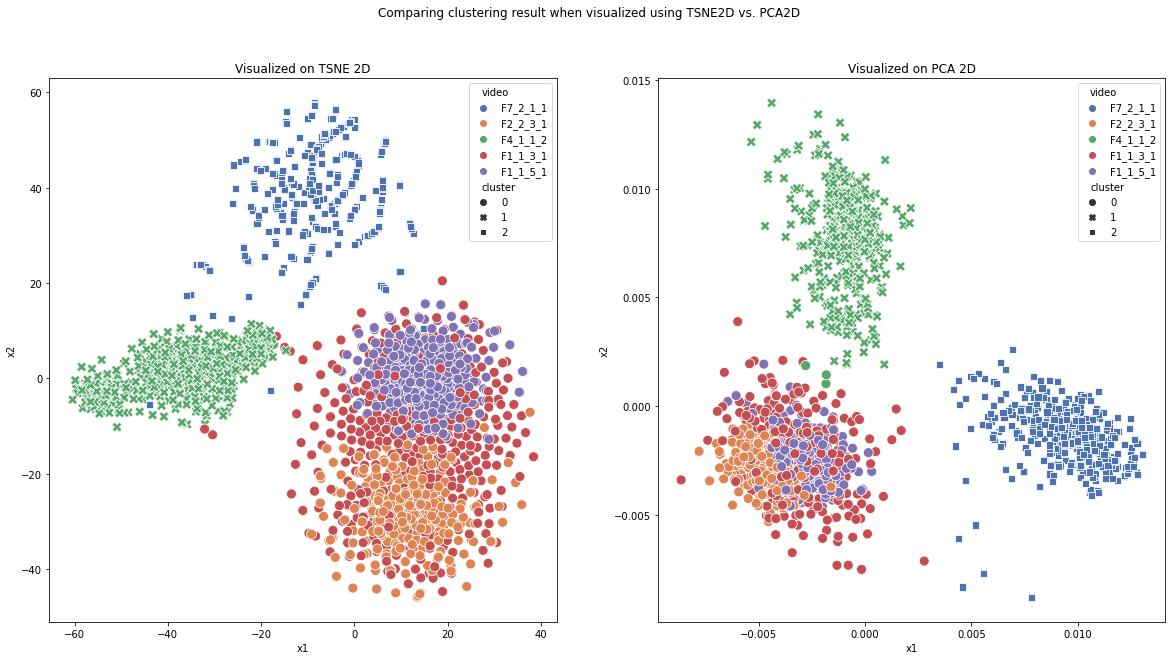

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))
sns.scatterplot(data=dftsne,x='x1',y='x2',hue='video',style='cluster',
                legend="full",alpha=1, palette="deep", ax=ax[0], s=100)
ax[0].set_title('Visualized on TSNE 2D')
sns.scatterplot(data=dfpca,x='x1',y='x2',hue='video',style='cluster',
                legend="full",alpha=1, palette="deep",ax=ax[1], s=100)
ax[1].set_title('Visualized on PCA 2D')
fig.suptitle('Comparing clustering result when visualized using TSNE2D vs. PCA2D')

## Гипотеза 1:
- взять df_val
- F2_231 F1_131 F1_151
- добавить F1_1_1_1, F1_1_2_1, F1_1_4_1

In [7]:
print(df_val.shape)
df_val.head()

(2006, 5)


,index,img_path,video,frame,train
0,9,F7_2_1_1.ts_f_1394.jpg,F7_2_1_1,f_1394.jpg,0
1,91,F2_2_3_1.ts_f_90.jpg,F2_2_3_1,f_90.jpg,0
2,140,F4_1_1_2.ts_f_1307.jpg,F4_1_1_2,f_1307.jpg,0
3,167,F4_1_1_2.ts_f_869.jpg,F4_1_1_2,f_869.jpg,0
4,185,F1_1_3_1.ts_f_322.jpg,F1_1_3_1,f_322.jpg,0


In [8]:
df_val = pd.concat([df_val,
                   df_train[df_train.video=='F1_1_1_1'].reset_index(),
                   df_train[df_train.video=='F1_1_2_1'].reset_index(),
                   df_train[df_train.video=='F1_1_4_1'].reset_index()]).reset_index()

In [9]:
print(df_val.shape)
df_val.head()

(3229, 6)


,level_0,index,img_path,video,frame,train
0,0,9,F7_2_1_1.ts_f_1394.jpg,F7_2_1_1,f_1394.jpg,0
1,1,91,F2_2_3_1.ts_f_90.jpg,F2_2_3_1,f_90.jpg,0
2,2,140,F4_1_1_2.ts_f_1307.jpg,F4_1_1_2,f_1307.jpg,0
3,3,167,F4_1_1_2.ts_f_869.jpg,F4_1_1_2,f_869.jpg,0
4,4,185,F1_1_3_1.ts_f_322.jpg,F1_1_3_1,f_322.jpg,0


In [11]:
%%time

emb = np.zeros((len(df_val),128))

for i in range(len(df_val)):
    path = all_frames_dir+df_val['img_path'][i] #4
    image = cv2.imread(path, cv2.IMREAD_UNCHANGED).astype(np.float32)/255.
    transformer = transforms.Compose([transforms.ToTensor(),])
    img = transformer(image)
    #see_plot(img.resize(224,224))
    my_model.eval()
    with torch.no_grad():
        sample_reconstructed, mu, log_var, z = my_model(img.reshape(1,1,224,224))
    mu = mu.detach().cpu().numpy().reshape(128)
    emb[i,:] = mu

CPU times: user 4min 43s, sys: 2.12 s, total: 4min 45s
Wall time: 35.7 s


In [12]:
Xtsne = TSNE(n_components=2,random_state=42).fit_transform(emb)
dftsne = pd.DataFrame(Xtsne)
dftsne.columns = ['x1','x2']
dftsne['video'] = df_val['img_path'].apply(lambda x: x.split('.ts')[0])

Xpca = PCA(n_components=2).fit_transform(emb)
dfpca = pd.DataFrame(Xpca)
dfpca.columns = ['x1','x2']
dfpca['video'] = df_val['img_path'].apply(lambda x: x.split('.ts')[0])

kmeans = KMeans(n_clusters=3, random_state=42)
dftsne['cluster'] = kmeans.fit_predict(emb)
dfpca['cluster'] = dftsne['cluster']

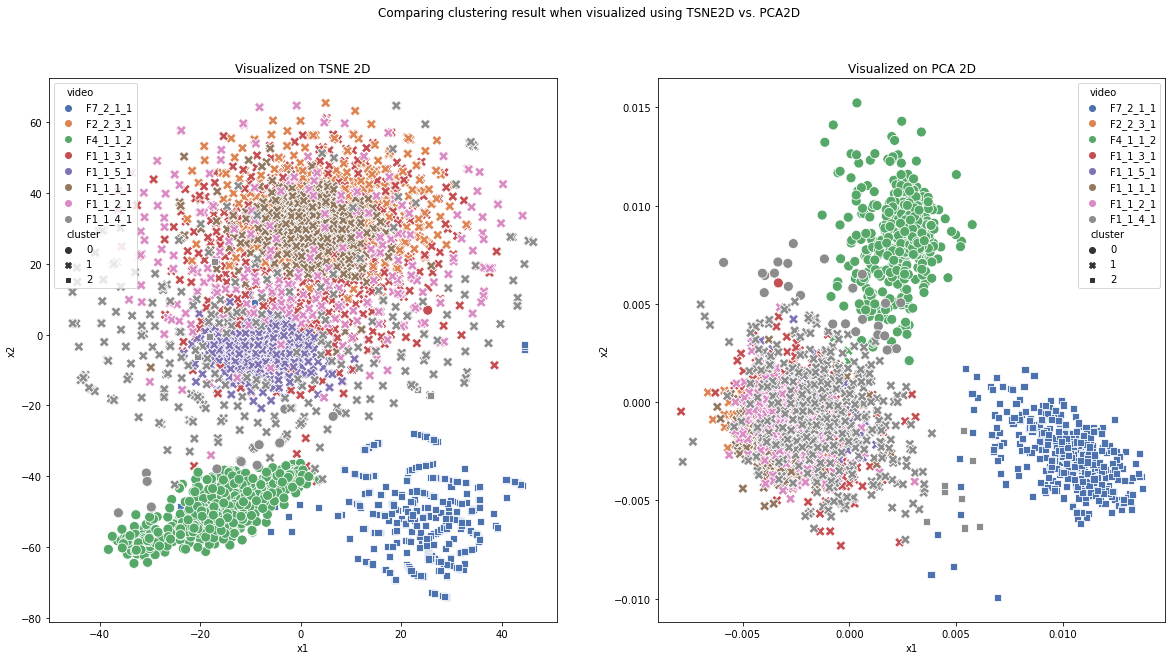

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))
sns.scatterplot(data=dftsne,x='x1',y='x2',hue='video',style='cluster',
                legend="full",alpha=1, palette="deep", ax=ax[0], s=100)
ax[0].set_title('Visualized on TSNE 2D')
sns.scatterplot(data=dfpca,x='x1',y='x2',hue='video',style='cluster',
                legend="full",alpha=1, palette="deep",ax=ax[1], s=100)
ax[1].set_title('Visualized on PCA 2D')
fig.suptitle('Comparing clustering result when visualized using TSNE2D vs. PCA2D');

## Гипотеза 2.1: 
- списка видосов в Гипотезе1 убрать видео: F7_2_1_1, F2_2_3_1, F4_1_1_2
- чтобы остались только след видосы: F1_1_1_1, F1_1_2_1, F1_1_3_1, F1_1_4_1, F1_1_5_1

In [27]:
df_val['g2'] = df_val['video'].apply(lambda x: 1 if x in ['F1_1_1_1','F1_1_2_1','F1_1_3_1','F1_1_4_1','F1_1_5_1'] else 0)
df_val = df_val[df_val.g2 == 1].reset_index()#drop(['level_0','index'], axis=1)

print(df_val.shape)
df_val.head()

(1938, 6)


,index,img_path,video,frame,train,g2
0,4,F1_1_3_1.ts_f_322.jpg,F1_1_3_1,f_322.jpg,0,1
1,12,F1_1_3_1.ts_f_1181.jpg,F1_1_3_1,f_1181.jpg,0,1
2,14,F1_1_5_1.ts_f_585.jpg,F1_1_5_1,f_585.jpg,0,1
3,18,F1_1_5_1.ts_f_575.jpg,F1_1_5_1,f_575.jpg,0,1
4,20,F1_1_3_1.ts_f_1105.jpg,F1_1_3_1,f_1105.jpg,0,1


In [29]:
%%time

emb = np.zeros((len(df_val),128))

for i in range(len(df_val)):
    path = all_frames_dir+df_val['img_path'][i] #4
    image = cv2.imread(path, cv2.IMREAD_UNCHANGED).astype(np.float32)/255.
    transformer = transforms.Compose([transforms.ToTensor(),])
    img = transformer(image)
    #see_plot(img.resize(224,224))
    my_model.eval()
    with torch.no_grad():
        sample_reconstructed, mu, log_var, z = my_model(img.reshape(1,1,224,224))
    mu = mu.detach().cpu().numpy().reshape(128)
    emb[i,:] = mu

CPU times: user 2min 49s, sys: 1.08 s, total: 2min 50s
Wall time: 21.3 s


In [30]:
Xtsne = TSNE(n_components=2,random_state=42).fit_transform(emb)
dftsne = pd.DataFrame(Xtsne)
dftsne.columns = ['x1','x2']
dftsne['video'] = df_val['img_path'].apply(lambda x: x.split('.ts')[0])

Xpca = PCA(n_components=2).fit_transform(emb)
dfpca = pd.DataFrame(Xpca)
dfpca.columns = ['x1','x2']
dfpca['video'] = df_val['img_path'].apply(lambda x: x.split('.ts')[0])

kmeans = KMeans(n_clusters=3, random_state=42)
dftsne['cluster'] = kmeans.fit_predict(emb)
dfpca['cluster'] = dftsne['cluster']

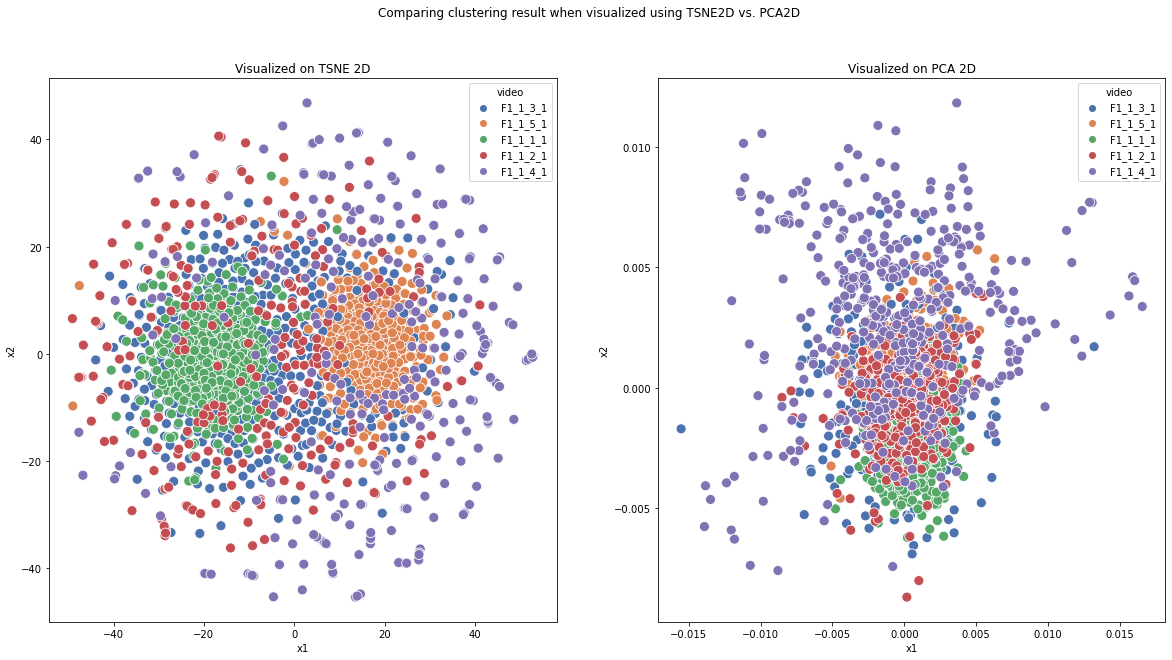

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))
sns.scatterplot(data=dftsne,x='x1',y='x2',hue='video',#style='cluster',
                legend="full",alpha=1, palette="deep", ax=ax[0], s=100)
ax[0].set_title('Visualized on TSNE 2D')
sns.scatterplot(data=dfpca,x='x1',y='x2',hue='video',#style='cluster',
                legend="full",alpha=1, palette="deep",ax=ax[1], s=100)
ax[1].set_title('Visualized on PCA 2D')
fig.suptitle('Comparing clustering result when visualized using TSNE2D vs. PCA2D');

## Гипотеза 2.2, эмбеддинги пены по одному каскаду различаются:

- F1_1_1_1 и F1_1_5_1

In [43]:
df_val = pd.concat([df[df.video== 'F1_1_1_1'],df[df.video== 'F1_1_5_1']]).reset_index()
print(df_val.shape)
df_val.head()

(664, 6)


,level_0,index,img_path,video,frame,train
0,31,155,F1_1_1_1.ts_f_546.jpg,F1_1_1_1,f_546.jpg,1
1,75,375,F1_1_1_1.ts_f_391.jpg,F1_1_1_1,f_391.jpg,1
2,158,790,F1_1_1_1.ts_f_855.jpg,F1_1_1_1,f_855.jpg,1
3,174,870,F1_1_1_1.ts_f_553.jpg,F1_1_1_1,f_553.jpg,1
4,225,1125,F1_1_1_1.ts_f_1488.jpg,F1_1_1_1,f_1488.jpg,1


CPU times: user 1min 5s, sys: 391 ms, total: 1min 6s
Wall time: 8.29 s


Text(0.5, 0.98, 'Comparing clustering result when visualized using TSNE2D vs. PCA2D')

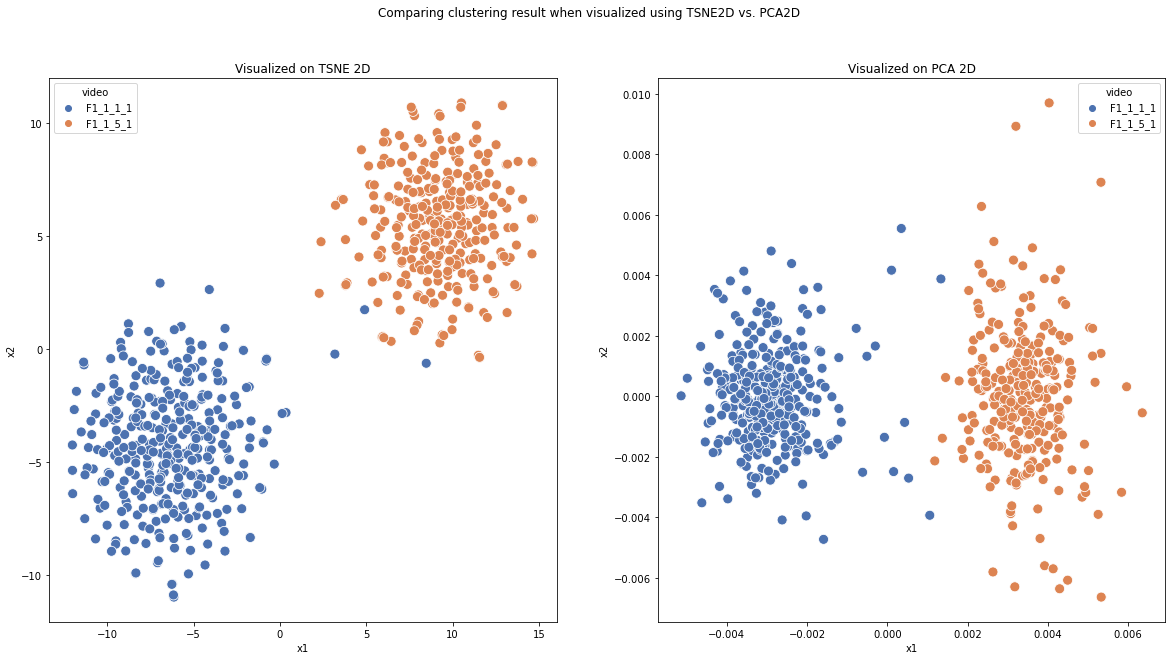

In [46]:
%%time

emb = np.zeros((len(df_val),128))

for i in range(len(df_val)):
    path = all_frames_dir+df_val['img_path'][i] #4
    image = cv2.imread(path, cv2.IMREAD_UNCHANGED).astype(np.float32)/255.
    transformer = transforms.Compose([transforms.ToTensor(),])
    img = transformer(image)
    #see_plot(img.resize(224,224))
    my_model.eval()
    with torch.no_grad():
        sample_reconstructed, mu, log_var, z = my_model(img.reshape(1,1,224,224))
    mu = mu.detach().cpu().numpy().reshape(128)
    emb[i,:] = mu
#===================================================================================    
Xtsne = TSNE(n_components=2,random_state=42).fit_transform(emb)
dftsne = pd.DataFrame(Xtsne)
dftsne.columns = ['x1','x2']
dftsne['video'] = df_val['img_path'].apply(lambda x: x.split('.ts')[0])

Xpca = PCA(n_components=2).fit_transform(emb)
dfpca = pd.DataFrame(Xpca)
dfpca.columns = ['x1','x2']
dfpca['video'] = df_val['img_path'].apply(lambda x: x.split('.ts')[0])

kmeans = KMeans(n_clusters=2, random_state=42)
dftsne['cluster'] = kmeans.fit_predict(emb)
dfpca['cluster'] = dftsne['cluster']
#===================================================================================
fig, ax = plt.subplots(1, 2, figsize=(20,10))
sns.scatterplot(data=dftsne,x='x1',y='x2',hue='video',#style='cluster',
                legend="full",alpha=1, palette="deep", ax=ax[0], s=100)
ax[0].set_title('Visualized on TSNE 2D')
sns.scatterplot(data=dfpca,x='x1',y='x2',hue='video',#style='cluster',
                legend="full",alpha=1, palette="deep",ax=ax[1], s=100)
ax[1].set_title('Visualized on PCA 2D')
fig.suptitle('Comparing clustering result when visualized using TSNE2D vs. PCA2D');

## Гипотеза 3:
- кластеризация каждого кадра из одного видео: F4_1_1_2\F4_1_1_1

In [36]:
df_val = df[df.video== 'F4_1_1_2'].reset_index()
print(df_val.shape)
df_val.head()

(351, 6)


,level_0,index,img_path,video,frame,train
0,4,20,F4_1_1_2.ts_f_1352.jpg,F4_1_1_2,f_1352.jpg,0
1,28,140,F4_1_1_2.ts_f_1307.jpg,F4_1_1_2,f_1307.jpg,0
2,35,175,F4_1_1_2.ts_f_1353.jpg,F4_1_1_2,f_1353.jpg,0
3,118,590,F4_1_1_2.ts_f_400.jpg,F4_1_1_2,f_400.jpg,0
4,141,705,F4_1_1_2.ts_f_91.jpg,F4_1_1_2,f_91.jpg,0


CPU times: user 34.1 s, sys: 239 ms, total: 34.4 s
Wall time: 4.3 s


Text(0.5, 0.98, 'Comparing clustering result when visualized using TSNE2D vs. PCA2D')

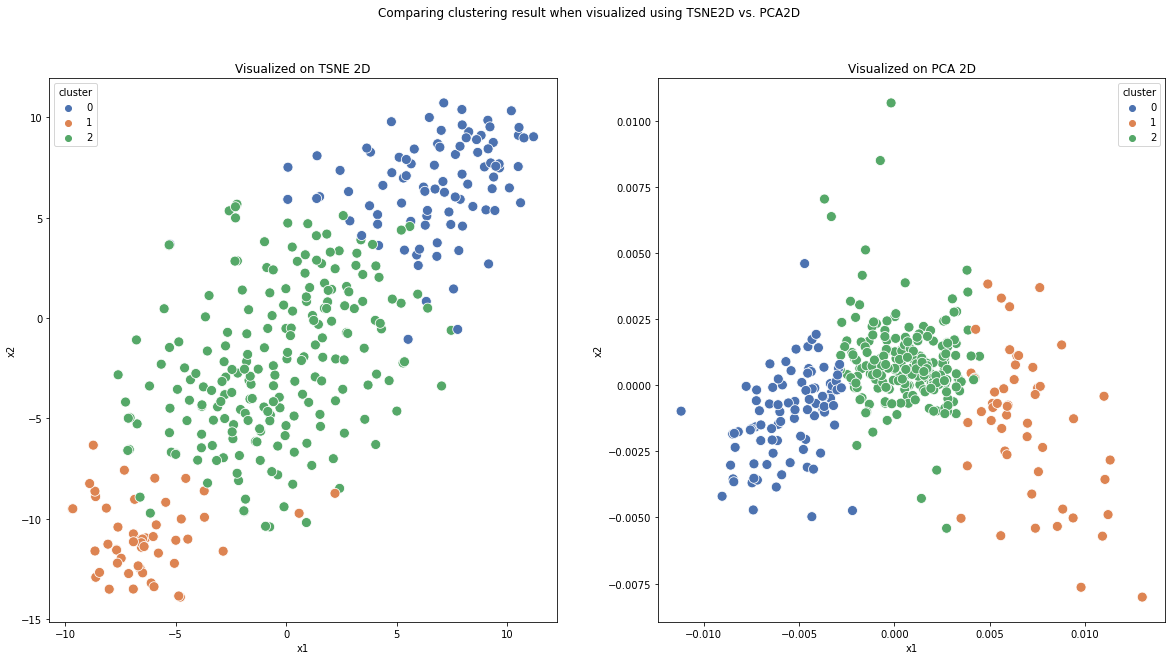

In [39]:
%%time

emb = np.zeros((len(df_val),128))

for i in range(len(df_val)):
    path = all_frames_dir+df_val['img_path'][i] #4
    image = cv2.imread(path, cv2.IMREAD_UNCHANGED).astype(np.float32)/255.
    transformer = transforms.Compose([transforms.ToTensor(),])
    img = transformer(image)
    #see_plot(img.resize(224,224))
    my_model.eval()
    with torch.no_grad():
        sample_reconstructed, mu, log_var, z = my_model(img.reshape(1,1,224,224))
    mu = mu.detach().cpu().numpy().reshape(128)
    emb[i,:] = mu
#===================================================================================    
Xtsne = TSNE(n_components=2,random_state=42).fit_transform(emb)
dftsne = pd.DataFrame(Xtsne)
dftsne.columns = ['x1','x2']
dftsne['video'] = df_val['img_path'].apply(lambda x: x.split('.ts')[0])

Xpca = PCA(n_components=2).fit_transform(emb)
dfpca = pd.DataFrame(Xpca)
dfpca.columns = ['x1','x2']
dfpca['video'] = df_val['img_path'].apply(lambda x: x.split('.ts')[0])

kmeans = KMeans(n_clusters=3, random_state=42)
dftsne['cluster'] = kmeans.fit_predict(emb)
dfpca['cluster'] = dftsne['cluster']
#===================================================================================
fig, ax = plt.subplots(1, 2, figsize=(20,10))
sns.scatterplot(data=dftsne,x='x1',y='x2',hue='cluster',#style='cluster',
                legend="full",alpha=1, palette="deep", ax=ax[0], s=100)
ax[0].set_title('Visualized on TSNE 2D')
sns.scatterplot(data=dfpca,x='x1',y='x2',hue='cluster',#style='cluster',
                legend="full",alpha=1, palette="deep",ax=ax[1], s=100)
ax[1].set_title('Visualized on PCA 2D')
fig.suptitle('Comparing clustering result when visualized using TSNE2D vs. PCA2D');

In [40]:
df_val = df[df.video== 'F4_1_1_1'].reset_index()
print(df_val.shape)
df_val.head()

(369, 6)


,level_0,index,img_path,video,frame,train
0,154,770,F4_1_1_1.ts_f_1607.jpg,F4_1_1_1,f_1607.jpg,1
1,193,965,F4_1_1_1.ts_f_285.jpg,F4_1_1_1,f_285.jpg,1
2,373,1865,F4_1_1_1.ts_f_1430.jpg,F4_1_1_1,f_1430.jpg,1
3,387,1935,F4_1_1_1.ts_f_1111.jpg,F4_1_1_1,f_1111.jpg,1
4,392,1960,F4_1_1_1.ts_f_1684.jpg,F4_1_1_1,f_1684.jpg,1


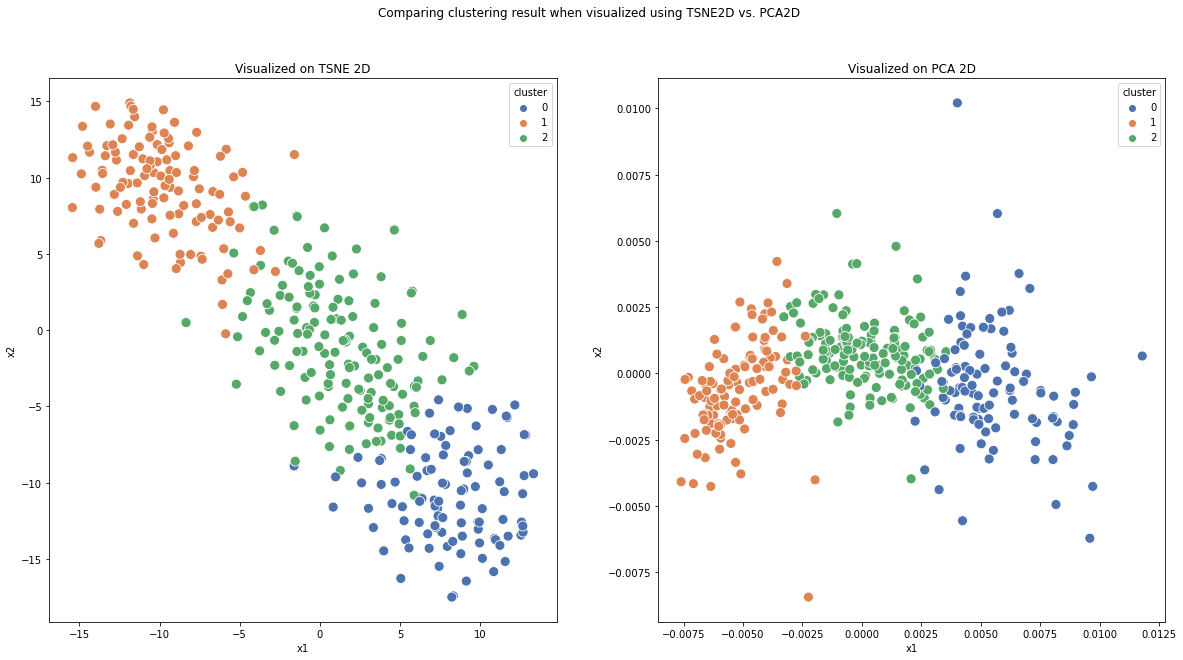

In [41]:
emb = np.zeros((len(df_val),128))

for i in range(len(df_val)):
    path = all_frames_dir+df_val['img_path'][i] #4
    image = cv2.imread(path, cv2.IMREAD_UNCHANGED).astype(np.float32)/255.
    transformer = transforms.Compose([transforms.ToTensor(),])
    img = transformer(image)
    #see_plot(img.resize(224,224))
    my_model.eval()
    with torch.no_grad():
        sample_reconstructed, mu, log_var, z = my_model(img.reshape(1,1,224,224))
    mu = mu.detach().cpu().numpy().reshape(128)
    emb[i,:] = mu
#===================================================================================    
Xtsne = TSNE(n_components=2,random_state=42).fit_transform(emb)
dftsne = pd.DataFrame(Xtsne)
dftsne.columns = ['x1','x2']
dftsne['video'] = df_val['img_path'].apply(lambda x: x.split('.ts')[0])

Xpca = PCA(n_components=2).fit_transform(emb)
dfpca = pd.DataFrame(Xpca)
dfpca.columns = ['x1','x2']
dfpca['video'] = df_val['img_path'].apply(lambda x: x.split('.ts')[0])

kmeans = KMeans(n_clusters=3, random_state=42)
dftsne['cluster'] = kmeans.fit_predict(emb)
dfpca['cluster'] = dftsne['cluster']
#===================================================================================
fig, ax = plt.subplots(1, 2, figsize=(20,10))
sns.scatterplot(data=dftsne,x='x1',y='x2',hue='cluster',#style='cluster',
                legend="full",alpha=1, palette="deep", ax=ax[0], s=100)
ax[0].set_title('Visualized on TSNE 2D')
sns.scatterplot(data=dfpca,x='x1',y='x2',hue='cluster',#style='cluster',
                legend="full",alpha=1, palette="deep",ax=ax[1], s=100)
ax[1].set_title('Visualized on PCA 2D')
fig.suptitle('Comparing clustering result when visualized using TSNE2D vs. PCA2D');

## Кластеризация кадров (каждый пятый) из всех видео

In [18]:
%%time

emb = np.zeros((len(df),128))

for i in range(len(df)):
    path = all_frames_dir+df['img_path'][i] #4
    image = cv2.imread(path, cv2.IMREAD_UNCHANGED).astype(np.float32)/255.
    transformer = transforms.Compose([transforms.ToTensor(),])
    img = transformer(image)
    #see_plot(img.resize(224,224))
    my_model.eval()
    with torch.no_grad():
        sample_reconstructed, mu, log_var, z = my_model(img.reshape(1,1,224,224))
    mu = mu.detach().cpu().numpy().reshape(128)
    emb[i,:] = mu

CPU times: user 27min 34s, sys: 11.3 s, total: 27min 45s
Wall time: 3min 28s


In [21]:
Xtsne = TSNE(n_components=2,random_state=42).fit_transform(emb)
dftsne = pd.DataFrame(Xtsne)
dftsne.columns = ['x1','x2']
dftsne['video'] = df['img_path'].apply(lambda x: x.split('.ts')[0])

Xpca = PCA(n_components=2).fit_transform(emb)
dfpca = pd.DataFrame(Xpca)
dfpca.columns = ['x1','x2']
dfpca['video'] = df['img_path'].apply(lambda x: x.split('.ts')[0])

kmeans = KMeans(n_clusters=3, random_state=42)
dftsne['cluster'] = kmeans.fit_predict(emb)
dfpca['cluster'] = dftsne['cluster']

In [25]:
dftsne.shape

(18384, 4)

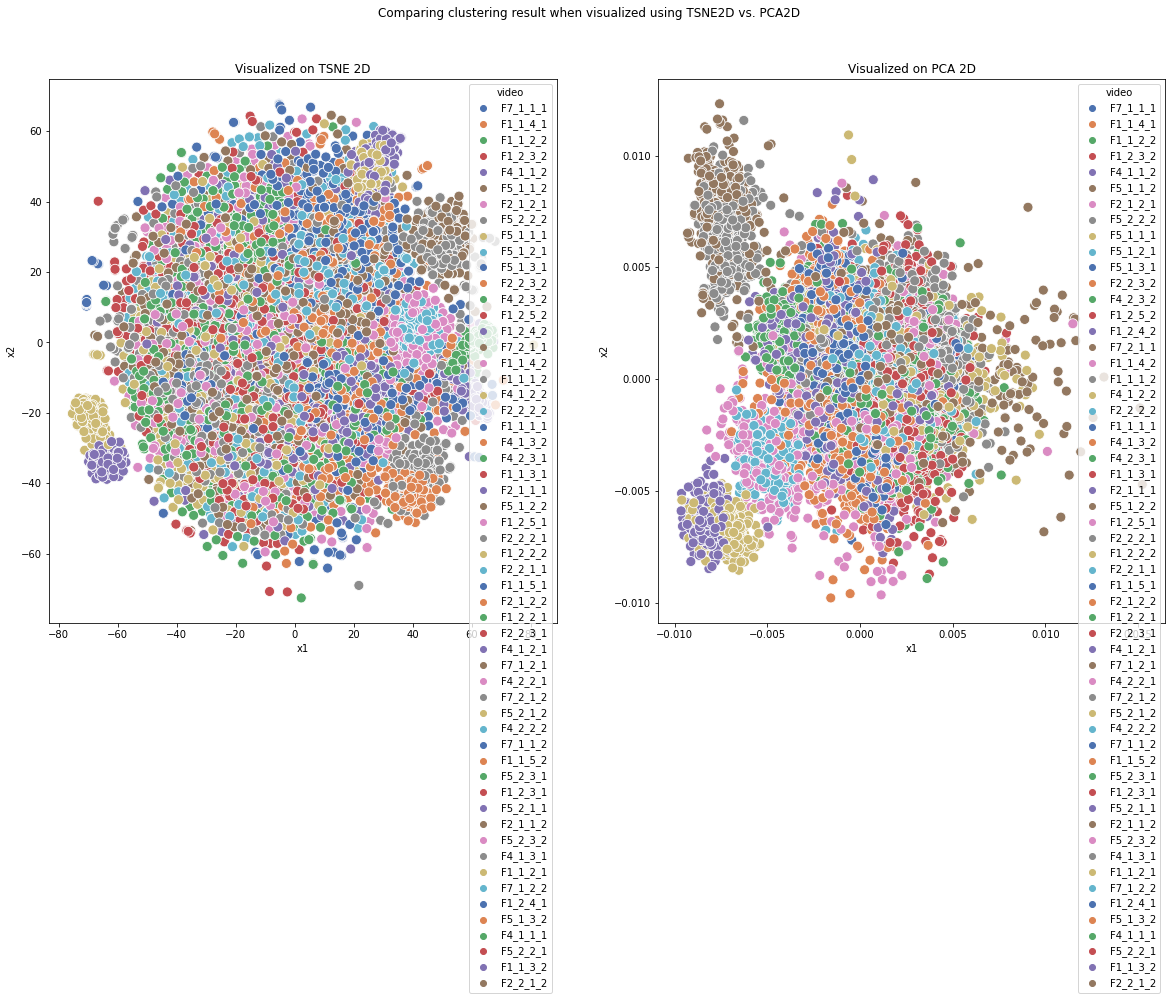

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))
sns.scatterplot(data=dftsne,x='x1',y='x2',hue='video',#style='cluster',
                legend="full",alpha=1, palette="deep", ax=ax[0], s=100)
ax[0].set_title('Visualized on TSNE 2D')
sns.scatterplot(data=dfpca,x='x1',y='x2',hue='video',#style='cluster',
                legend="full",alpha=1, palette="deep",ax=ax[1], s=100)
ax[1].set_title('Visualized on PCA 2D')
fig.suptitle('Comparing clustering result when visualized using TSNE2D vs. PCA2D');